In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow_datasets as tfds


In [3]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)
print(p_camelyon_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

In [4]:
from tensorflow.keras.applications import EfficientNetB0


# Resizing the images, based on the model choice. For EfficientNetB0 the size is 224
# Preparing inputs: categorical encoding
image_size = 224
size = (image_size, image_size)

# Defining a function to process the data: images and labels
def process(data):
  image, label = data['image'], data['label']
  label = tf.one_hot(label, 2, dtype=tf.float32)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size)
  return image, label


# Preparing the train, validation and test datasets
train = p_camelyon['train']
validation = p_camelyon['validation']
test = p_camelyon['test']

# Applying function to the three datasets
train = train.map(process, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.batch(batch_size = 16, drop_remainder = True)
train = train.prefetch(tf.data.AUTOTUNE)

validation = validation.map(process, num_parallel_calls=tf.data.AUTOTUNE)
validation = validation.batch(batch_size = 32, drop_remainder = True)
validation = validation.prefetch(tf.data.AUTOTUNE)

test = test.map(process, num_parallel_calls = tf.data.AUTOTUNE)
test = test.batch(batch_size = 32, drop_remainder = True)


#Seperating image and label into different variables
train_images, train_labels = next(iter(train))
valid_images, valid_labels = next(iter(validation))
test_images, test_labels  = next(iter(test))

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  input = layers.Input(shape=(image_size, image_size, 3))
  output = EfficientNetB0(include_top = True, weights = None, classes = 2, classifier_activation="softmax")(input)

  model = tf.keras.Model(input, output)
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 4
hist = model.fit(train, epochs = epochs, validation_data = validation, verbose = 1, steps_per_epoch = 512, validation_steps = 128)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 2)                4052133   
                                                                 
Total params: 4,052,133
Trainable params: 4,010,110
Non-trainable params: 42,023
_________________________________________________________________
Epoch 1/4
512/512 [==============================] - 106s 169ms/step - loss: 0.8399 - accuracy: 0.7203 - val_loss: 2.7052 - val_accuracy: 0.5066
Epoch 2/4
512/512 [==============================] - 85s 166ms/step - loss: 0.5593 - accuracy: 0.7679 - val_loss: 0.7191 - val_accuracy: 0.7053
Epoch 3/4
512/512 [==============================] - 86s 167ms/step - loss: 0.4844 - accuracy: 0.8033 - val_loss: 0.4503 - val_accuracy: 0.8013
Epoch 4/4

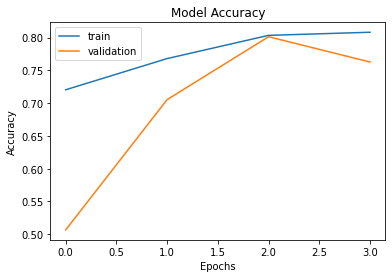

In [6]:
import matplotlib.pyplot as plt

def plot_hist(hist):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

plot_hist(hist)

In [8]:
'''# Confusion matrix

from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


metrics.ConfusionMatrixDisplay.from_predictions(train_images, hist)
plt.show()

metrics.ConfusionMatrixDisplay.from_predictions(valid_images, valid_labels)
plt.show()


cm = confusion_matrix(validation, hist, labels=valid_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=valid_labels)
disp.plot()

plt.show()'''

ValueError: ignored